In [1]:
%load_ext autoreload
%autoreload 2

In [69]:
import pandas as pd
from preprocessing import load_if_in_country_or_lang
from preprocessing import categorize_views_for_df
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_regression_results_from_dict
import numpy as np

In [479]:
df_crawled.sort_values('event_date')

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat,view_country_article
815,Q21683348,2015 Milano–Torino,2015-10-01,Global North,Italy,Europe,sports,"['Category:2015 UCI Europe Tour', 'Category:20...",554,21.000000,...,2015,30306.122125,1.835899e+12,True,2015-10-01,2.527000e+07,False,False,>10^7,10735.0
579,Q20976914,2015 Tour de Corse,2015-10-01,Global North,France,Europe,sports,['Category:2015 World Rally Championship seaso...,659,0.000000,...,2015,36611.753912,2.438208e+12,True,2015-10-01,9.448800e+07,False,False,>10^7,13390.0
11981,Q21057315,Deslizamiento de tierra en El Cambray II de 2015,2015-10-01,Global South,Guatemala,North America,disaster,"['Categoría:Desastres naturales en Guatemala',...",2800,0.000000,...,2015,3826.262816,6.218606e+10,False,2015-10-01,1.788500e+07,True,False,>10^7,3335.0
7619,Q20976914,Rallye Korsika 2015,2015-10-01,Global North,France,Europe,sports,"['Kategorie:Rallye-WM-Lauf 2015', 'Kategorie:R...",307,14.857143,...,2015,36611.753912,2.438208e+12,True,2015-10-01,6.093000e+06,False,False,>10^6,4190.0
11980,Q21036673,Masacre del Instituto Superior Umpqua de 2015,2015-10-01,Global North,United States,North America,disaster,"['Categoría:Estados Unidos en 2015', 'Categorí...",267,0.000000,...,2015,56738.091771,1.820602e+13,True,2015-10-01,6.104100e+07,False,False,>10^7,10519.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Q104579536,2020 Gjerdrum landslide,2020-12-30,Global North,Norway,Europe,disaster,"['Category:2020 disasters in Europe', 'Categor...",38328,0.000000,...,2020,66870.730726,3.625223e+11,True,2020-12-01,2.763000e+07,False,False,>10^7,8266.0
11703,Q104579536,Avalancha de Gjerdrum de 2020,2020-12-30,Global North,Norway,Europe,disaster,"['Categoría:Corrimientos de tierra', 'Categorí...",24,0.000000,...,2020,66870.730726,3.625223e+11,True,2020-12-01,2.120000e+05,False,False,>10^5,2070.0
85,Q104621508,Killing of Dolal Idd,2020-12-30,Global North,United States,North America,disaster,['Category:2020 controversies in the United St...,21836,0.000000,...,2020,63122.594145,2.089375e+13,True,2020-12-01,3.166022e+09,True,True,>10^9,45086.0
84,Q104588556,2021 New Year Honours (New Zealand),2020-12-31,Global North,New Zealand,Oceania,culture,"['Category:2021 awards', 'Category:2021 in New...",1875,291.857143,...,2020,43972.130573,2.120439e+11,True,2020-12-01,4.048600e+07,True,False,>10^7,16604.0


In [3]:
df_crawled = load_preprocessed_events()
df_crawled = load_if_in_country_or_lang(df_crawled)
df_crawled = categorize_views_for_df(df_crawled)
df_crawled.event_date = pd.to_datetime(df_crawled.event_date)
df_crawled.head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",248274,0.000000,...,Pakistan,2016,1362.860008,2.775210e+11,False,2016-12-01,8.684000e+07,True,False,>10^7
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.000000,...,United States,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True,>10^9
2,Q100256872,Killing of Babu Lal Vaishnav,2020-10-08,Global South,India,Asia,disaster,"['Category:2020 crimes in India', 'Category:20...",427,0.000000,...,India,2020,1930.971218,2.664749e+12,False,2020-10-01,7.142770e+08,True,False,>10^8
3,Q100279235,Miss Vietnam 2020,2020-11-20,Global South,Vietnam,Asia,culture,"['Category:2020 beauty pageants', 'Category:Be...",1444,49.285714,...,Vietnam,2020,2785.724225,2.711584e+11,False,2020-11-01,1.619000e+07,False,False,>10^7
4,Q100288161,2020 Ganja missile attacks,2020-10-11,Global South,Azerbaijan,Asia,disaster,"['Category:2020 in Azerbaijan', 'Category:Arti...",7410,0.000000,...,Azerbaijan,2020,4202.232239,4.260718e+10,False,2020-10-01,3.088000e+06,False,False,>10^6


In [4]:
from preprocessing import replace_country_names
df_pageviews_all = pd.read_csv(f'countries/pageviews_countries.csv')
df_pageviews_all.date = pd.to_datetime(df_pageviews_all.date)
df_pageviews_all['month_year'] = df_pageviews_all.apply(lambda row: f'{row.date.year}-{row.date.month:02d}', axis=1)
df_pageviews_all['date_month'] = df_pageviews_all.apply(lambda row: pd.to_datetime(f'{row.month_year}-01'), axis=1)
replace_country_names(df_pageviews_all, inplace=True)
df_pageviews_all = df_pageviews_all.rename({view_col: view_col.replace('views_', '') for view_col in df_pageviews_all.columns if view_col.startswith('views_')}, axis=1)

In [5]:
from dateutil.relativedelta import relativedelta
def get_pageviews_baseline(row, df_pageviews, ts_months, pre_period = 0, func=np.median):
    return np.median(df_pageviews[(df_pageviews.en_article == row.country) & (df_pageviews.date >= (row.event_date - relativedelta(months=ts_months, days=pre_period))) & (df_pageviews.date < (row.event_date - relativedelta(days=pre_period)))][row.code])

df_crawled['view_country_article'] = df_crawled.apply(lambda row: get_pageviews_baseline(row, df_pageviews_all, 5), axis=1)

# Regression

In [7]:
from regression import fit_nb_with_estimated_alpha, estimate_alpha, fit_nb, standardize_var, fit_nb_with_estimated_alpha_all_codes

In [126]:
df_filtered = df_crawled[(df_crawled.cat != 'undefined') & (df_crawled.views_7_sum > 10)].copy()
df_filtered['GDP_pc_z'] = standardize_var(df_filtered, 'GDP_pc')
df_filtered['gdp_z'] = standardize_var(df_filtered, 'GDP')
df_filtered['pop_z'] = standardize_var(df_filtered, 'population')
df_filtered['views_baseline_z'] = standardize_var(df_filtered, 'views_baseline')
df_filtered['view_country_article_z'] = standardize_var(df_filtered, 'view_country_article')
df_filtered['bing_hits_z'] = standardize_var(df_filtered, 'bing_hits')
df_filtered['worldwide'] = df_filtered.code.apply(lambda c: (c == 'en') or (c=='es'))
df_filtered['view_country_article_log'] = np.log1p(df_filtered.view_country_article)
df_filtered['views_baseline_log'] = np.log1p(df_filtered.views_baseline)
df_filtered['bing_hits_log'] = np.log1p(df_filtered.bing_hits)
df_filtered['GDP_pc_log'] = np.log1p(df_filtered.GDP_pc)
df_filtered['GDP_log'] = np.log1p(df_filtered.GDP)
df_filtered['population_log'] = np.log1p(df_filtered.population)

baselines = {'gni_class': 'H', 'in_code_lang': True, 'gni_region': 'East Asia & Pacific', 'cat': 'culture', 'code': 'en'} #{'gni_class': 'H', 'in_code_lang': True, 'gni_region': 'North America', 'cat': 'sports', 'code': 'en'},
cat_dict = {'en': 'English', 'it': 'Italian', 'es': 'Spanish', 'de': 'German'}
label_renames = {'Middle East & North Africa': 'MENAf', 'Latin America & Caribbean': 'LatAmC',
               'Europe & Central Asia': 'EuCAs', 'East Asia & Pacific': 'EAsP', 'North America': 'NAm',
               'Sub-Saharan Africa': 'SSAf', 'South Asia': 'SAs', 'gdp_pc_z': 'GDP pc (norm.)',
                 'GDP_pc_log': 'GDP pc',
                 'bing_hits_log': 'Bing', 'view_country_article_log': 'Cntry-Art\nViews', 'views_baseline_log': 'Cntry\nViews',
                  'bing_hits_z': 'Bing (z)', 'view_country_article_z': 'Cntry-Art\nViews (z)', 'views_baseline_z': 'Cntry\nViews (z)'
                }

In [114]:
nb_fit_dict = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ view_country_article_log + views_baseline_log + bing_hits_log + cat + GDP_pc_log', est_method='lbfgs',
                                                   output_lvl=2)

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 13.993412331573403 (p=0.0005972312345643641)
Deviance: 2112.17 | Null-deviance: 2317.81
Pseudo ChiSq: 8481.95 | Good-Fit-ChiSq): 7801.90
Pseudo R² (1 - D/D_0) = 0.0887
H0: Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.1163
--------------- Summary for en ---------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:            views_7_sum   No. Observations:                 7606
Model:                            GLM   Df Residuals:                     7598
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -87308.
Date:                Wed, 13 Apr 2022   Deviance:                    

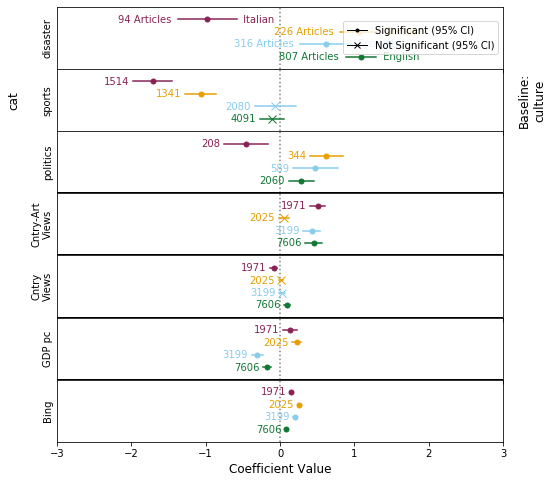

In [116]:


fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict, ['cat', 'view_country_article_log', 'views_baseline_log', 'GDP_pc_log', 'bing_hits_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-3, 3))

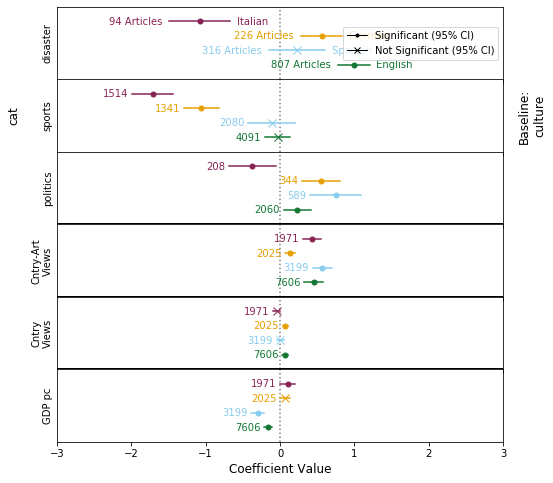

In [121]:
nb_fit_dict = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ view_country_article_log + views_baseline_log + cat + GDP_pc_log', est_method='lbfgs',
                                                   output_lvl=0)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict, ['cat', 'view_country_article_log', 'views_baseline_log', 'GDP_pc_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-3, 3))

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 15.325288025949709 (p=5.862139316540675e-05)
Deviance: 1974.95 | Null-deviance: 2116.38
Pseudo ChiSq: 7781.86 | Good-Fit-ChiSq): 7802.91
Pseudo R² (1 - D/D_0) = 0.0668
H0: Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.0241
--------------- Summary for en ---------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:            views_7_sum   No. Observations:                 7606
Model:                            GLM   Df Residuals:                     7599
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -87826.
Date:                Wed, 13 Apr 2022   Deviance:                    

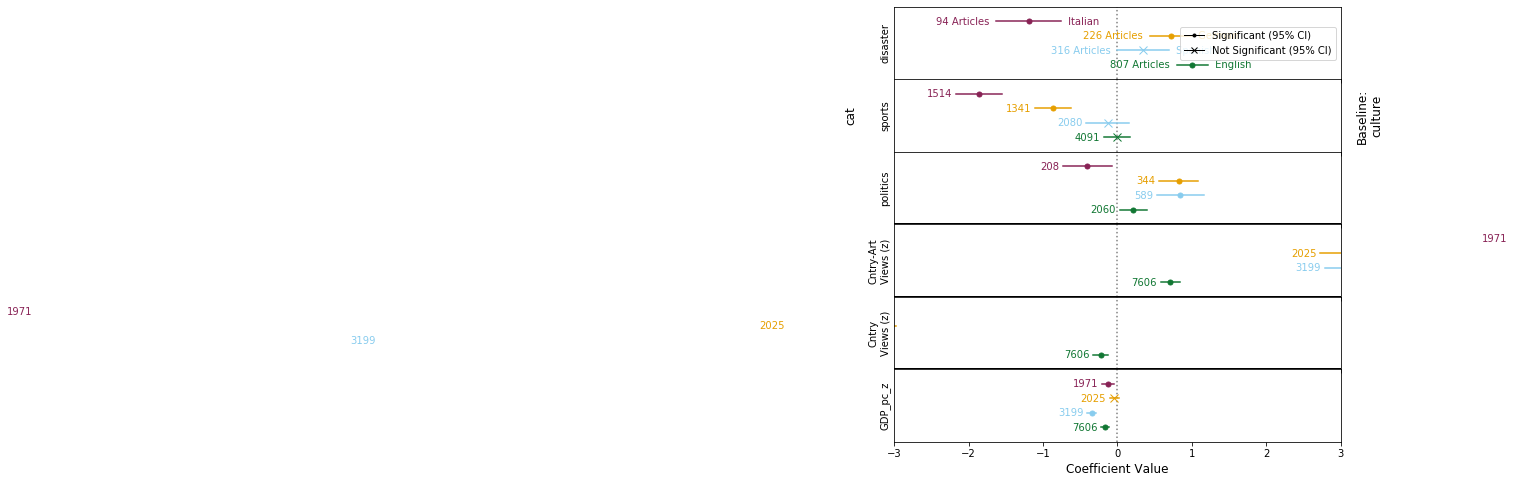

In [129]:
nb_fit_dict = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ view_country_article_z + views_baseline_z + cat + GDP_pc_z', est_method='lbfgs',
                                                   output_lvl=2)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict, ['cat', 'view_country_article_z', 'views_baseline_z', 'GDP_pc_z'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-3, 3))

In [59]:
nb_catfit = fit_nb_with_estimated_alpha_all_codes(
    ['en', 'es', 'de', 'it'], df_filtered, 
    'views_7_sum ~ cat + gni_region + gdp_pc_z', est_method='lbfgs')

for key, vals in nb_fit_dict.items():
    display(f'---------------- Summary for {key} ----------------')
    display(vals.summary())
    #print(vals.mle_retvals)

 ================= Fitting en =================
Estimated alpha as 16.267516056065215 (p=0.00019268036784355402)
Deviance: 1899.234081326846|Null-deviance: 1993.8006687953239|Chi-sq ("good fit"): 7798.855100752451
Pseudo R² (1 - D/D_0) = 0.04743031184035862
H0: Model provides adequate fit for data: p=1.0
Overdispersion factor:  1.1436058222833054
 ================= Fitting es =================
Estimated alpha as 17.174659527290537 (p=0.001257028823711992)
Deviance: 720.0386656485529|Null-deviance: 797.9987555264927|Chi-sq ("good fit"): 3320.468491979389
Pseudo R² (1 - D/D_0) = 0.0976945005716261
H0: Model provides adequate fit for data: p=1.0
Overdispersion factor:  1.4347696236876386
 ================= Fitting de =================
Estimated alpha as 6.937692951000248 (p=0.08734139901404232)
Deviance: 1134.164146942369|Null-deviance: 1372.771948114716|Chi-sq ("good fit"): 2119.5177487008445
Pseudo R² (1 - D/D_0) = 0.17381459571638025
H0: Model provides adequate fit for data: p=1.0
Over

'---------------- Summary for en ----------------'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 7606
Model:                            GLM   Df Residuals:                     7596
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -88180.
Date:                Thu, 07 Apr 2022   Deviance:                       1898.0
Time:                        15:19:55   Pearson chi2:                 8.72e+03
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   10.2916      0.201     51.076      0.000       9.897      10.686
cat[T.disaster]                              0.8541      0.219      3.904      0.000       0.425       1.283
cat[T.politics]                              0.1040      0.184      0.566      0.571      -0.256       0.464
cat[T.sports]                               -0.1660      0.176     -0.942      0.346      -0.512       0.179
gni_region[T.Europe & Central Asia]         -0.0224      0.141     -0.159      0.874      -0.299       0.254
gni_region[T.Latin America & Caribbean]      0.2717      0.192      1.415      0.157      -0.105       0.648
gni_region[T.Middle East & North Africa]     0.2351      0.289      0.814      0.415      -0.331       0.801
gni_region[T.North America]                  0.6340      0.154      4.110      0.000       0.332       0.936
gni_region[T.South Asia]                     0.2305      0.306      0.753      0.451      -0.369       0.830
gni_region[T.Sub-Saharan Africa]            -0.2287      0.318     -0.719      0.472      -0.852       0.395
============================================================================================================
"""

'---------------- Summary for es ----------------'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 3199
Model:                            GLM   Df Residuals:                     3189
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -32195.
Date:                Thu, 07 Apr 2022   Deviance:                       723.60
Time:                        15:19:55   Pearson chi2:                 5.65e+03
No. Iterations:                    17                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    8.6426      0.407     21.259      0.000       7.846       9.439
cat[T.disaster]                              0.4041      0.384      1.052      0.293      -0.349       1.157
cat[T.politics]                              0.7595      0.337      2.253      0.024       0.099       1.420
cat[T.sports]                               -0.0200      0.315     -0.064      0.949      -0.638       0.598
gni_region[T.Europe & Central Asia]         -0.2735      0.281     -0.974      0.330      -0.824       0.277
gni_region[T.Latin America & Caribbean]      0.7105      0.307      2.315      0.021       0.109       1.312
gni_region[T.Middle East & North Africa]    -0.0717      0.492     -0.146      0.884      -1.036       0.893
gni_region[T.North America]                  0.6293      0.376      1.676      0.094      -0.107       1.365
gni_region[T.South Asia]                    -0.4327      0.744     -0.581      0.561      -1.892       1.026
gni_region[T.Sub-Saharan Africa]            -0.9385      0.575     -1.633      0.102      -2.065       0.188
============================================================================================================
"""

'---------------- Summary for de ----------------'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 2025
Model:                            GLM   Df Residuals:                     2015
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -19576.
Date:                Thu, 07 Apr 2022   Deviance:                       1122.4
Time:                        15:19:55   Pearson chi2:                 7.42e+03
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    9.1776      0.331     27.718      0.000       8.529       9.827
cat[T.disaster]                              0.3560      0.330      1.080      0.280      -0.290       1.002
cat[T.politics]                              0.3886      0.301      1.292      0.196      -0.201       0.978
cat[T.sports]                               -1.4052      0.285     -4.934      0.000      -1.963      -0.847
gni_region[T.Europe & Central Asia]          0.8866      0.191      4.630      0.000       0.511       1.262
gni_region[T.Latin America & Caribbean]      0.8158      0.286      2.853      0.004       0.255       1.376
gni_region[T.Middle East & North Africa]     0.5353      0.331      1.616      0.106      -0.114       1.185
gni_region[T.North America]                  0.6808      0.259      2.633      0.008       0.174       1.187
gni_region[T.South Asia]                    -0.4197      0.466     -0.900      0.368      -1.334       0.494
gni_region[T.Sub-Saharan Africa]            -0.3127      0.405     -0.771      0.440      -1.107       0.482
============================================================================================================
"""

'---------------- Summary for it ----------------'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 1971
Model:                            GLM   Df Residuals:                     1961
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -18294.
Date:                Thu, 07 Apr 2022   Deviance:                       740.79
Time:                        15:19:55   Pearson chi2:                 4.14e+03
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    9.8230      0.413     23.769      0.000       9.013      10.633
cat[T.disaster]                             -1.3179      0.451     -2.923      0.003      -2.202      -0.434
cat[T.politics]                             -0.3868      0.355     -1.091      0.275      -1.082       0.308
cat[T.sports]                               -1.9289      0.288     -6.690      0.000      -2.494      -1.364
gni_region[T.Europe & Central Asia]          0.3591      0.316      1.136      0.256      -0.260       0.978
gni_region[T.Latin America & Caribbean]     -0.1909      0.348     -0.548      0.584      -0.874       0.492
gni_region[T.Middle East & North Africa]     0.2085      0.518      0.402      0.687      -0.807       1.224
gni_region[T.North America]                  0.8933      0.391      2.286      0.022       0.127       1.659
gni_region[T.South Asia]                    -0.6304      1.130     -0.558      0.577      -2.846       1.585
gni_region[T.Sub-Saharan Africa]             0.0048      0.720      0.007      0.995      -1.406       1.416
============================================================================================================
"""

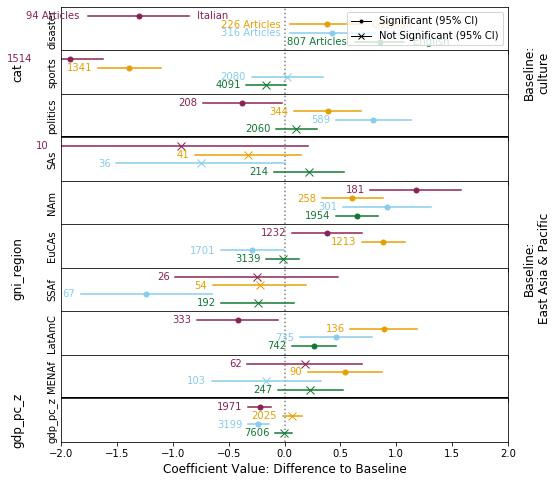

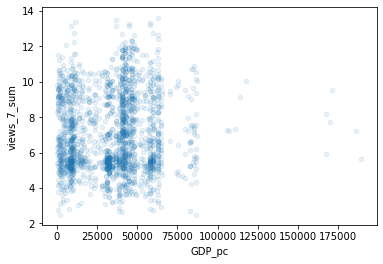

In [299]:
df_inv = df_rel.copy()
df_inv.views_7_sum = np.log1p(df_inv.views_7_sum)
df_inv['gdp_pc_log'] = np.log1p(df_inv.GDP_pc)
df_inv.sort_values('GDP_pc').plot(x='GDP_pc', y='views_7_sum', kind='scatter', alpha=0.1)

In [23]:
nb_fitall = fit_nb_with_estimated_alpha(df_filtered, 'views_7_sum ~ code * ((np.log1p(view_country_article) + np.log1p(views_baseline) + np.log1p(bing_hits) + cat + np.log1p(GDP_pc)) + gni_region)', est_method='lbfgs')
#print(nb_fitall.mle_retvals)
nb_fitall.summary()

Estimated alpha as 13.089981994736995 (p=1.4672109268928817e-06)
Deviance: 4183.567613429867|Null-deviance: 5577.999163952445|Chi-sq ("good fit"): 15028.597450677476
Pseudo R² (1 - D/D_0) = 0.24998776613916074
H0: Model provides adequate fit for data: p=1.0
Overdispersion factor:  1.2011773987440082


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                14801
Model:                            GLM   Df Residuals:                    14745
Model Family:        NegativeBinomial   Df Model:                           55
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:            -1.5723e+05
Date:                Thu, 07 Apr 2022   Deviance:                       4183.6
Time:                        13:50:33   Pearson chi2:                 1.77e+04
No. Iterations:                   360                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               5.1452      1.238      4.157      0.000       2.719       7.571
code[T.en]                                             -0.6031      1.505     -0.401      0.689      -3.553       2.347
code[T.es]                                              1.6199      1.747      0.927      0.354      -1.805       5.045
code[T.it]                                              0.7278      2.067      0.352      0.725      -3.323       4.778
cat[T.disaster]                                         1.0922      0.450      2.428      0.015       0.211       1.974
cat[T.politics]                                         0.6381      0.399      1.598      0.110      -0.145       1.421
cat[T.sports]                                          -1.1093      0.368     -3.011      0.003      -1.831      -0.387
gni_region[T.Europe & Central Asia]                     0.3062      0.282      1.084      0.278      -0.247       0.860
gni_region[T.Latin America & Caribbean]                 0.5163      0.403      1.281      0.200      -0.274       1.307
gni_region[T.Middle East & North Africa]                0.3201      0.488      0.655      0.512      -0.637       1.277
gni_region[T.North America]                             0.1031      0.367      0.281      0.779      -0.615       0.822
gni_region[T.South Asia]                               -0.4662      0.671     -0.695      0.487      -1.781       0.849
gni_region[T.Sub-Saharan Africa]                       -0.1091      0.615     -0.177      0.859      -1.314       1.096
code[T.en]:cat[T.disaster]                             -0.0761      0.492     -0.155      0.877      -1.041       0.889
code[T.es]:cat[T.disaster]                             -0.3992      0.561     -0.711      0.477      -1.499       0.701
code[T.it]:cat[T.disaster]                             -1.8775      0.687     -2.733      0.006      -3.224      -0.531
code[T.en]:cat[T.politics]                             -0.3768      0.433     -0.871      0.384      -1.225       0.471
code[T.es]:cat[T.politics]                             -0.1379      0.497     -0.278      0.781      -1.112       0.836
code[T.it]:cat[T.politics]                             -1.0273      0.553     -1.859      0.063      -2.111       0.056
code[T.en]:cat[T.sports]                                0.9351      0.402      2.329      0.020       0.148       1.722
code[T.es]:cat[T.sports]                                1.0605      0.461      2.302      0.021       0.158       1.963
code[T.it]:cat[T.sports]                               -0.4837      0.514     -0.941      0.347      -1.491       0.524
code[T.en]:gni_region[T.Europe & Central Asia]         -0.3210      0.312     -1.02